***
*Workshop:* [TTSM (Technology & Thought in Sonic Media) summer school 2024](https://ttsm.link/) 

*Instructor:* Jingwei Liu (Ph.D. candidate, Music department, UC San Diego)
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">Workshop</span> 


# Symbolic Music Data Processing (MIDI)

In [2]:
from music21 import *
import py_midicsv as pm
import pandas as pd
import numpy as np

In [2]:
# pip install music21

*Package introduction*
- [Music21](https://web.mit.edu/music21/doc/about/what.html) was a Python-based toolkit for computer-aided musicology.
- [py_midicsv](https://pypi.org/project/py-midicsv/) is a Python library that bidirectionally convert between the binary MIDI format and a human-readable interpretation of the contained data in text format, expressed as CSV.
- [pandas](https://pandas.pydata.org/docs/user_guide/10min.html#min) is a python data analysis library.
- [numpy](https://numpy.org/) is the fundamental package for scientific computing with Python.

Convert MIDI to CSV:

In [60]:
file = "Songs\cs1-1pre.mid" #cs1-1pre e_piano_comp
csv_string = pm.midi_to_csv(file)
csv_string

['0, 0, Header, 1, 17, 480\n',
 '1, 0, Start_track\n',
 '1, 0, Title_t, "untitled"\n',
 '1, 0, SMPTE_offset, 96, 0, 3, 0, 0\n',
 '1, 0, Time_signature, 4, 2, 24, 8\n',
 '1, 0, Key_signature, 1, "major"\n',
 '1, 0, Tempo, 750000\n',
 '1, 41040, Tempo, 3000000\n',
 '1, 41280, Tempo, 779221\n',
 '1, 41280, End_track\n',
 '2, 0, Start_track\n',
 '2, 0, MIDI_port, 0\n',
 '2, 0, Title_t, "Solo Cello"\n',
 '2, 0, Program_c, 0, 42\n',
 '2, 0, Control_c, 0, 7, 100\n',
 '2, 0, Control_c, 0, 10, 64\n',
 '2, 0, Note_on_c, 0, 43, 100\n',
 '2, 120, Note_on_c, 0, 43, 0\n',
 '2, 120, Note_on_c, 0, 50, 100\n',
 '2, 240, Note_on_c, 0, 50, 0\n',
 '2, 240, Note_on_c, 0, 59, 100\n',
 '2, 360, Note_on_c, 0, 59, 0\n',
 '2, 360, Note_on_c, 0, 57, 100\n',
 '2, 480, Note_on_c, 0, 57, 0\n',
 '2, 480, Note_on_c, 0, 59, 100\n',
 '2, 600, Note_on_c, 0, 59, 0\n',
 '2, 600, Note_on_c, 0, 50, 100\n',
 '2, 720, Note_on_c, 0, 50, 0\n',
 '2, 720, Note_on_c, 0, 59, 100\n',
 '2, 840, Note_on_c, 0, 59, 0\n',
 '2, 840, Note_

In [61]:
MyFile = open("Aligned.txt","w")

for element in csv_string:
    inst_list = element.split(", ");
    inst_list_len = len(inst_list)
    
    if inst_list_len == 6 and inst_list[2][-2:] != "_t": # exclude the coincidences when text events happen to have 6 entries
        element = ','.join(inst_list)
            
    else:
        if inst_list_len == 3 and ','.join(inst_list)[-1] == "\n": # 'End_of_fil'
            element = ','.join(inst_list)[:-1] + ',-1'*3 + "\n"
        else:
            element = ','.join(inst_list[0:3]) + ',-1'*3 + ',' + ' '.join(inst_list[3:])

    MyFile.write(element)
    
MyFile.close()

In [62]:
df = pd.read_csv('Aligned.txt', sep=",",names = ["Track","Time","Type","Channel", "Note", "Velocity","Value"])
print(df)

      Track  Time            Type  Channel  Note  Velocity  \
0         0     0          Header        1    17       480   
1         1     0     Start_track       -1    -1        -1   
2         1     0         Title_t       -1    -1        -1   
3         1     0    SMPTE_offset       -1    -1        -1   
4         1     0  Time_signature       -1    -1        -1   
...     ...   ...             ...      ...   ...       ...   
1391     17     0     Start_track       -1    -1        -1   
1392     17     0       MIDI_port       -1    -1        -1   
1393     17     0         Title_t       -1    -1        -1   
1394     17     0       End_track       -1    -1        -1   
1395      0     0     End_of_file       -1    -1        -1   

                                Value  
0                                 NaN  
1                                 NaN  
2                            untitled  
3                          96 0 3 0 0  
4                            4 2 24 8  
...            

In [63]:
gk = df.groupby('Type',as_index = False)
gk.size()

,Type,size
0,Control_c,6
1,End_of_file,1
2,End_track,17
3,Header,1
4,Key_signature,1
5,MIDI_port,16
6,Note_on_c,1312
7,Program_c,3
8,SMPTE_offset,1
9,Start_track,17


Please refer to [Midi-CSV file format](https://www.fourmilab.ch/webtools/midicsv/#:~:text=The%20midicsv%20and%20csvmidi%20programs%20allow%20you%20to,all%20the%20information%20in%20the%20original%20MIDI%20file) for MIDI metadata explanation.

Now we will look into some selected MIDI events, and learn how to process the messages into useful musical information.


### 1) Header

0, 0, __Header__, format, nTracks, division

The first record of a CSV MIDI file is always the Header record. Parameters are format: the MIDI file type (0, 1, or 2), nTracks: the number of tracks in the file, and __division: the number of clock pulses per quarter note__. The Track and Time fields are always zero.

The header is in the main file, we can get this record:

In [10]:
Header = df[df['Type']=='Header'].reset_index(drop=True)
Header

,Track,Time,Type,Channel,Note,Velocity,Value
0,0,0,Header,0,1,480,NaN


Usually there is only one *Header* event at the top of each MIDI file, from which the most important information is the "division", pulse per quarter note (PPQ).

In [11]:
PPQ = Header['Velocity'][0]
PPQ

480

### 2) Tempo

Track, Time, __Tempo__, Number

The tempo is specified as **the number of microseconds per quarter note**, between 1 and 16777215. A value of 500000 corresponds to 120 quarter notes (“beats”) per minute. To convert beats per minute to a Tempo value, take the quotient from dividing 60,000,000 by the beats per minute (BPM).

In [13]:
Tempo = df[df['Type']=='Tempo'].reset_index(drop=True)
Tempo

,Track,Time,Type,Channel,Note,Velocity,Value
0,1,0,Tempo,-1,-1,-1,512820


Usually the *Tempo* is specified at the beginning of the MIDI file at Time 0. There could be multiple Tempo events as the BPM may change at certain time points across the corpus. Here we only take the first Tempo message for example:

In [14]:
MSQ = int(Tempo['Value'][0])  # microseconds per quarter note
MSQ

512820

In [15]:
BPM = 60000000/MSQ
BPM

117.000117000117

With PPQ and MSQ, we are able to discuss *Time* in MIDI appropriately. Now let's proceed to the most important event in a MIDI file, *Note*.

### 3）Note

Track, Time, __Note_on_c__, Channel, Note, Velocity

Send a command to play the specified Note (Middle C is defined as Note number 60; all other notes are relative in the MIDI specification, but most instruments conform to the well-tempered scale) on the given Channel with Velocity (0 to 127). A Note_on_c event with Velocity zero is equivalent to a Note_off_c.

Track, Time, **Note_off_c**, Channel, Note, Velocity

Stop playing the specified Note on the given Channel. The Velocity should be zero, but you never know what you'll find in a MIDI file.

In [70]:
Note_on = df[df['Type']=='Note_on_c'].reset_index(drop=True)
Note_on

,Track,Time,Type,Channel,Note,Velocity,Value
0,2,0,Note_on_c,0,43,100,NaN
1,2,120,Note_on_c,0,43,0,NaN
2,2,120,Note_on_c,0,50,100,NaN
3,2,240,Note_on_c,0,50,0,NaN
4,2,240,Note_on_c,0,59,100,NaN
...,...,...,...,...,...,...,...
1307,3,72960,Note_on_c,1,50,0,NaN
1308,3,78720,Note_on_c,1,59,100,NaN
1309,3,80640,Note_on_c,1,59,0,NaN
1310,4,78720,Note_on_c,2,43,100,NaN


In [71]:
row = len(Note_on)
Note_off = pd.DataFrame(columns=['Track','Time','Type','Channel','Note','Velocity'])
for i in range (row):
    if Note_on["Velocity"][i] == 0:
        
        Note_off = pd.concat([Note_off, pd.DataFrame([{
            'Track': Note_on['Track'][i],
             'Time': Note_on['Time'][i],
             'Type': " Note_off_c",
             'Channel': Note_on['Channel'][i],                       
             'Note': Note_on['Note'][i],
             'Velocity': 0
             }])], ignore_index=True)
        
        Note_on = Note_on.drop(i) 
        
Note_off = Note_off.astype({
    'Track': np.int64,
    'Time': np.int64,
    'Channel': np.int64,
    'Note': np.int64,
    'Velocity': np.int64
})

In [72]:
Note_on = Note_on.reset_index(drop=True)
Note_on

,Track,Time,Type,Channel,Note,Velocity,Value
0,2,0,Note_on_c,0,43,100,NaN
1,2,120,Note_on_c,0,50,100,NaN
2,2,240,Note_on_c,0,59,100,NaN
3,2,360,Note_on_c,0,57,100,NaN
4,2,480,Note_on_c,0,59,100,NaN
...,...,...,...,...,...,...,...
651,3,72360,Note_on_c,1,50,100,NaN
652,3,72600,Note_on_c,1,50,100,NaN
653,3,72840,Note_on_c,1,50,100,NaN
654,3,78720,Note_on_c,1,59,100,NaN


In [73]:
Note_off

,Track,Time,Type,Channel,Note,Velocity
0,2,120,Note_off_c,0,43,0
1,2,240,Note_off_c,0,50,0
2,2,360,Note_off_c,0,59,0
3,2,480,Note_off_c,0,57,0
4,2,600,Note_off_c,0,59,0
...,...,...,...,...,...,...
651,3,72480,Note_off_c,1,50,0
652,3,72720,Note_off_c,1,50,0
653,3,72960,Note_off_c,1,50,0
654,3,80640,Note_off_c,1,59,0


In [74]:
len(Note_on) == len(Note_off)

True

Now that we have on_set and off_set for each note, we are able to calculate an important quantity, *Duration*. For example, for the first note,

In [75]:
on_set = Note_on['Time'][0]
on_set

0

In [76]:
off_set = Note_off['Time'][0]
off_set

120

In [77]:
Duration = off_set - on_set
Duration

120

The Duaration is in MIDI clock. To convert it to human readable time, we write

In [78]:
Duration_quarter = Duration/PPQ
Duration_quarter

0.25

It means the note of duration 120 equals to 1/4 quarter note, namely a 16th note.

In [79]:
Duration_ms = Duration/PPQ * MSQ
Duration_ms

187500.0

This note lasts 0.1875 seconds in real time.

Now we can process the *Note* events into a new table, characterized by various types of time stamps and durations:

In [80]:
row = len(Note_on)
Notes = pd.DataFrame(columns=['Track','Time_on','Time_on_quarter','Time_on_ms','Channel','Note','Velocity','Duration','Duration_quarter','Duration_ms'])
Note_off_copy = Note_off.copy()
Note_off_copy
row2 = len(Note_off_copy)

for i in range(row):
    note_value = Note_on["Note"][i]
    time_on = Note_on["Time"][i]
    for j in range(row2):
        if Note_off_copy["Note"][j] == Note_on["Note"][i] and Note_on["Track"][i] == Note_off_copy["Track"][j] and Note_on["Channel"][i] == Note_off_copy["Channel"][j]:
        
            time_off = Note_off_copy["Time"][j]
            Duration = time_off - time_on
            Duration_quarter = Duration/PPQ
            Duration_ms = Duration/PPQ * MSQ
            
            Note_off_copy = Note_off_copy.drop(j)
            Note_off_copy = Note_off_copy.reset_index(drop=True)
            row2 = len(Note_off_copy)
            Notes = pd.concat([Notes, pd.DataFrame([{'Track': Note_on["Track"][i],
                        'Time_on': time_on,
                        'Time_on_quarter': time_on/PPQ,
                        'Time_on_ms': time_on/PPQ* MSQ,
                        'Channel': Note_on["Channel"][i],
                         'Note': note_value,
                         'Velocity': Note_on["Velocity"][i],
                        'Duration': Duration,
                          'Duration_quarter': Duration_quarter,
                         'Duration_ms': Duration_ms}])], ignore_index=True)
            break
            
Notes = Notes.astype({
    'Track': np.int64,
    'Time_on': np.int64,
    'Time_on_ms': np.int64,
    'Channel': np.int64,
    'Note': np.int64,
    'Velocity': np.int64,
    'Duration': np.int64,
    'Duration_ms': np.int64
})

In [81]:
Notes

,Track,Time_on,Time_on_quarter,Time_on_ms,Channel,Note,Velocity,Duration,Duration_quarter,Duration_ms
0,2,0,0.00,0,0,43,100,120,0.25,187500
1,2,120,0.25,187500,0,50,100,120,0.25,187500
2,2,240,0.50,375000,0,59,100,120,0.25,187500
3,2,360,0.75,562500,0,57,100,120,0.25,187500
4,2,480,1.00,750000,0,59,100,120,0.25,187500
...,...,...,...,...,...,...,...,...,...,...
651,3,72360,150.75,113062500,1,50,100,120,0.25,187500
652,3,72600,151.25,113437500,1,50,100,120,0.25,187500
653,3,72840,151.75,113812500,1,50,100,120,0.25,187500
654,3,78720,164.00,123000000,1,59,100,1920,4.00,3000000


Change BPM:

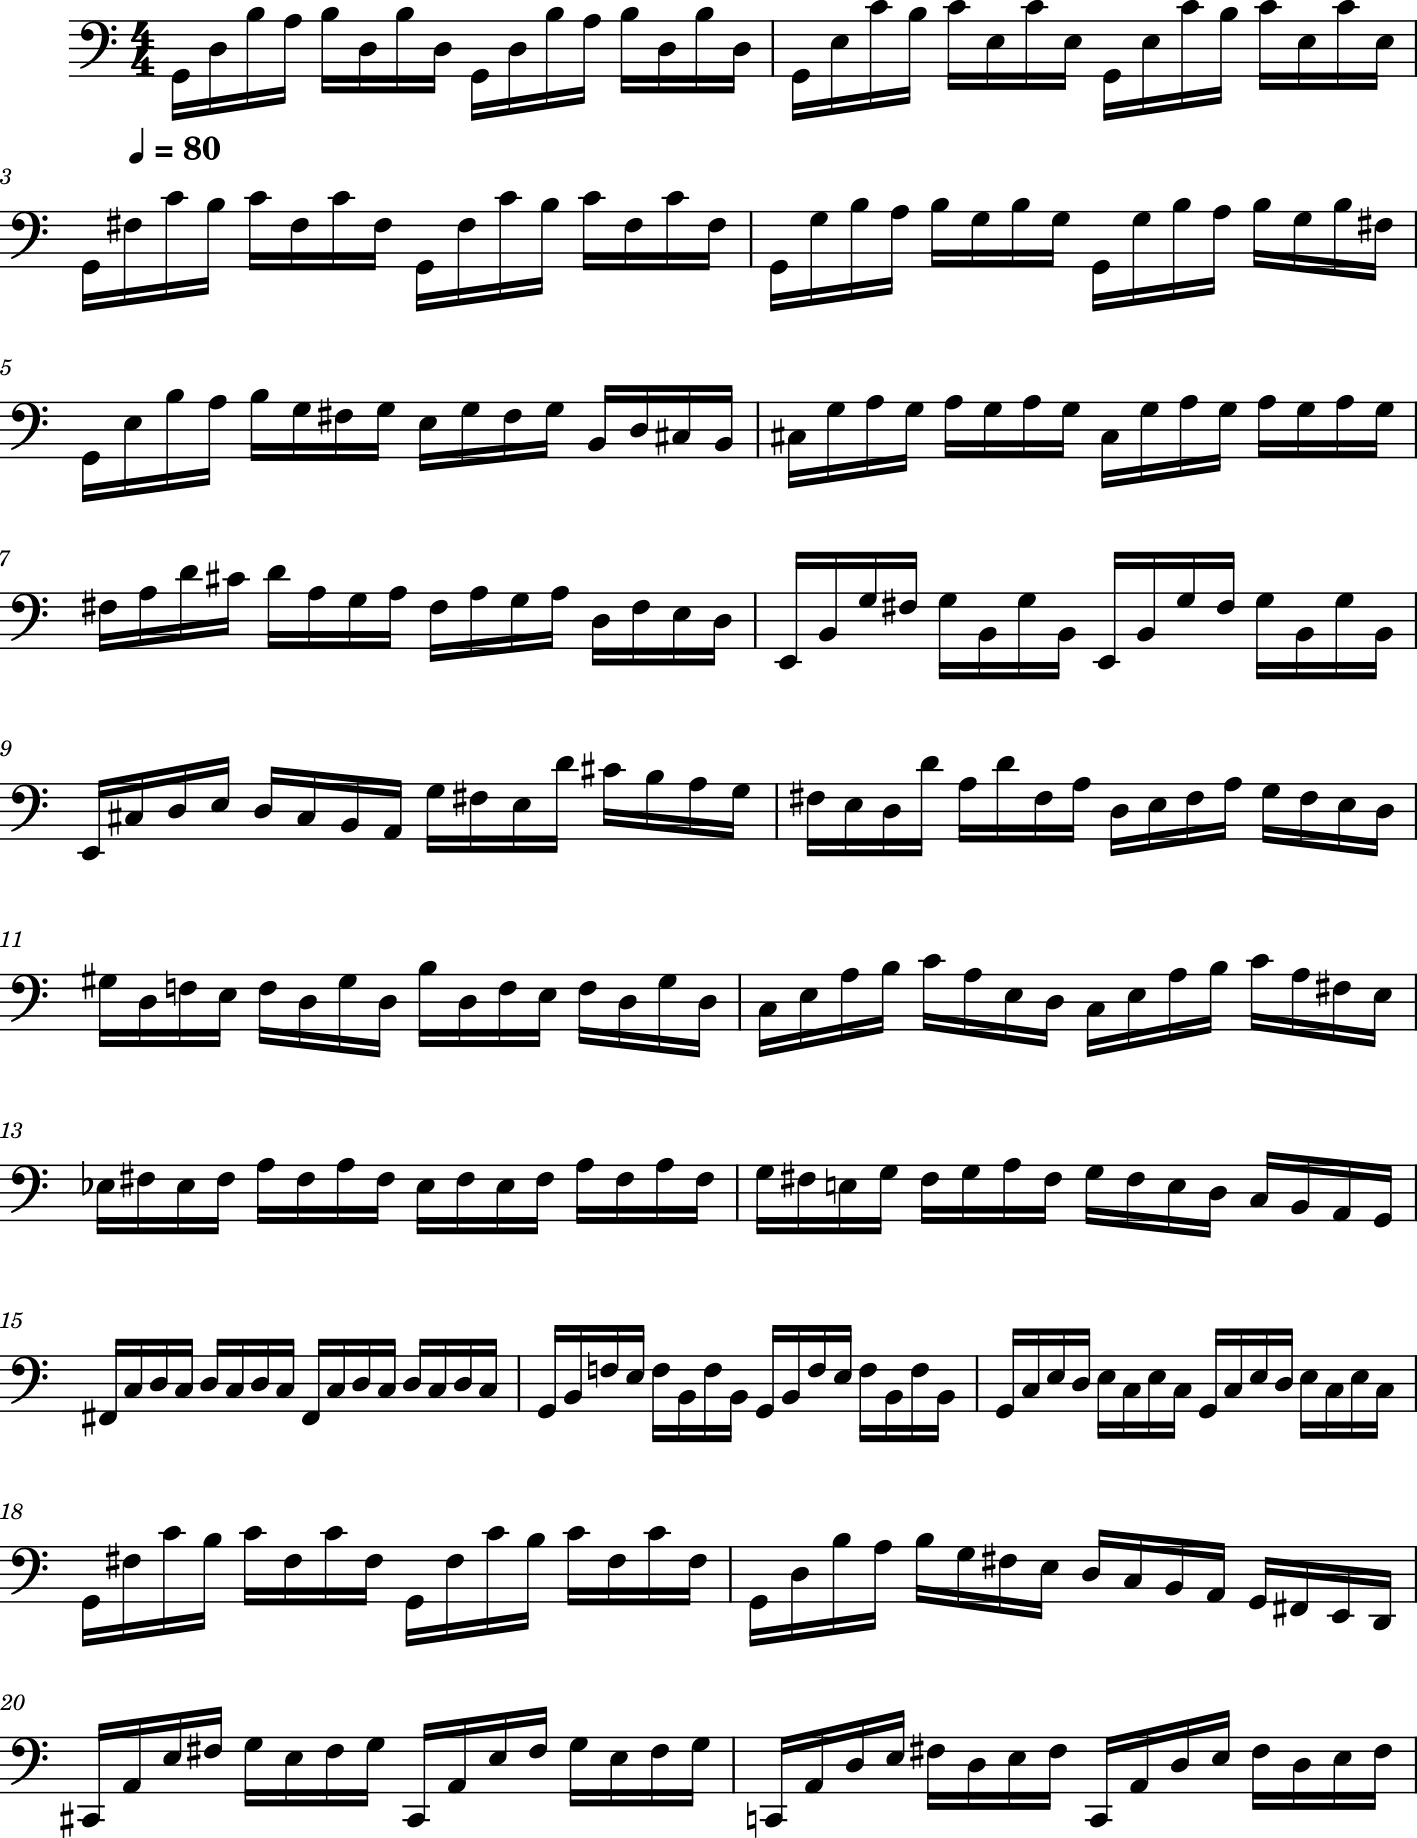

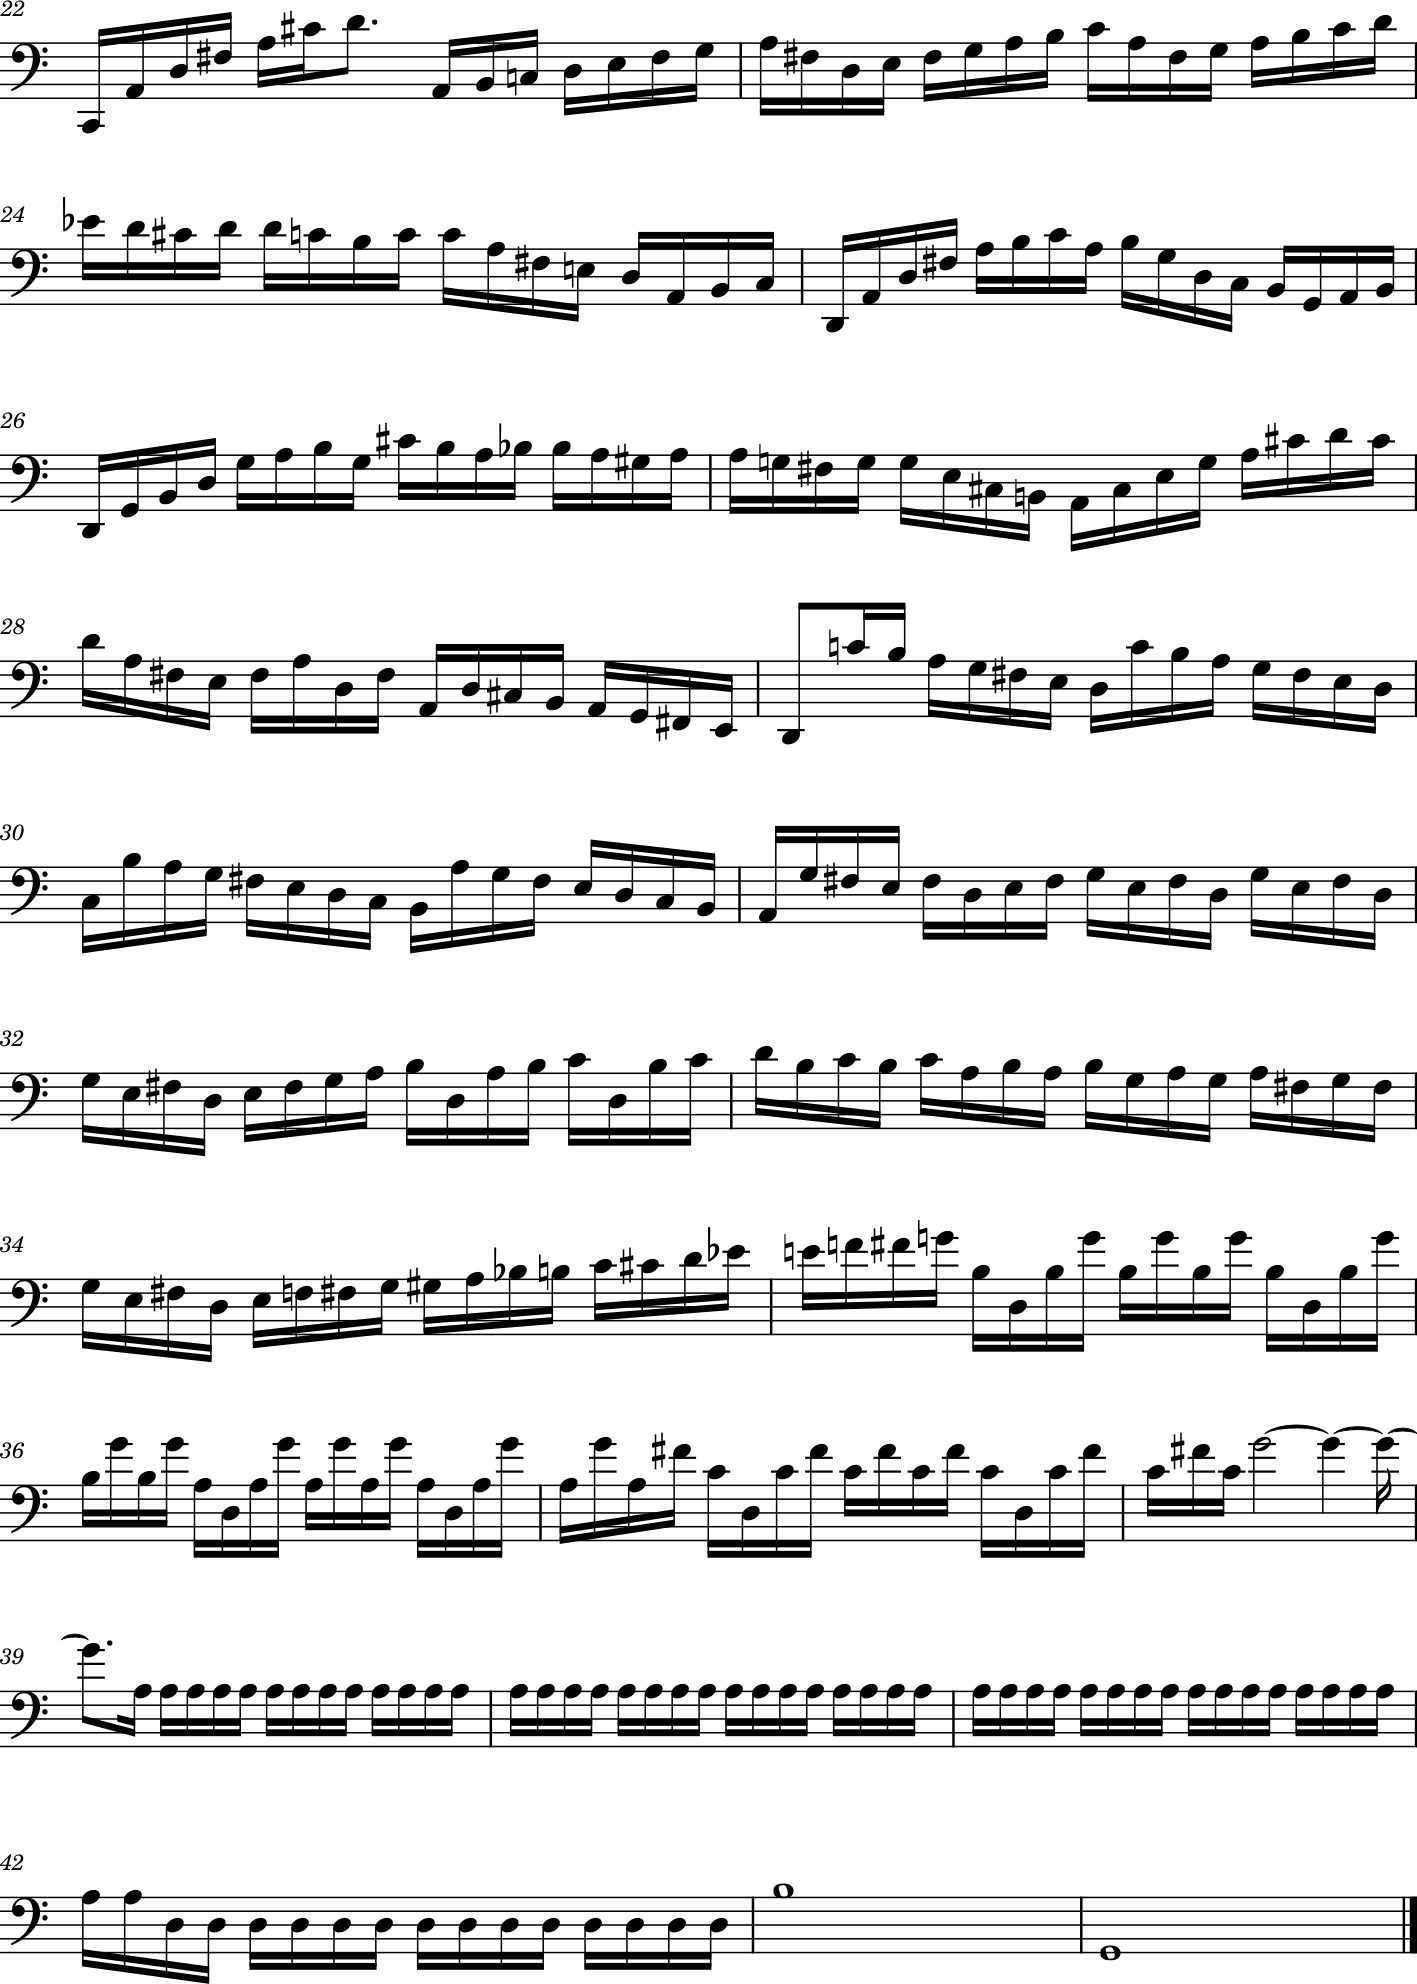

In [82]:
strm = stream.Stream()
mm = tempo.MetronomeMark(number=BPM)
strm.append(mm)  # tempo
strm.append(instrument.Violoncello())  # instrument
for i in range(len(Notes)):
    n = note.Note()
    n.pitch.midi = Notes['Note'][i]
    n.duration.quarterLength = Notes['Duration_quarter'][i]
    strm.append(n)
strm.show()

In [83]:
strm.show('mid')

*Question 1*: Compare the score of "cs1-1pre.mid" and "cs2-1pre.mid", and think about how tempo plays a role in notational music. How human beings process this information and how about computers? How about neural networks?

### 4) Time Signature

Track, Time, **Time_signature**, Num, Denom, Click, NotesQ

The time signature, metronome click rate, and number of 32nd notes per MIDI quarter note (24 MIDI clock times) are given by the numeric arguments. Num gives the numerator of the time signature as specified on sheet music. Denom specifies the denominator as a negative power of two, for example 2 for a quarter note, 3 for an eighth note, etc. Click gives the number of MIDI clocks per metronome click, and NotesQ the number of 32nd notes in the nominal MIDI quarter note time of 24 clocks (8 for the default MIDI quarter note definition).

In [84]:
Time_signature = df[df['Type']=='Time_signature'].reset_index(drop=True)
Time_signature

,Track,Time,Type,Channel,Note,Velocity,Value
0,1,0,Time_signature,-1,-1,-1,4 2 24 8


In [85]:
Ts = Time_signature['Value'][0].split(" ")
Ts

['4', '2', '24', '8']

In [26]:
[Num, Denom, Click, NotesQ] = list(map(int, Ts))
print("Time signature: " + str(Num) +"/" + str(2**Denom))

Time signature: 4/4


In [86]:
[Num, Denom, Click, NotesQ] = list(map(int, Ts))
beat_number_per_measure = Num
beat_quarterLength = 4/(2**int(Denom))
print("beat_number_per_measure: "+ str(beat_number_per_measure))
print("beat_quarterLength: " + str(beat_quarterLength))

beat_number_per_measure: 4
beat_quarterLength: 1.0


In [87]:
measure_quarterLength = beat_number_per_measure * beat_quarterLength
measure_quarterLength

4.0

In [88]:
Beat_level = pd.DataFrame(columns=['Track','Time_on_quarter','Channel','Note','Velocity','Duration_quarter','Structure_level'])
row = len(Notes)

for i in range(row):
    onset = Notes["Time_on_quarter"][i]
    flag = 0
    if onset%measure_quarterLength == 0:
        level = 0
        flag = 1
    elif onset%beat_quarterLength == 0:
        level = 1
        flag = 1
    else:
        le = beat_quarterLength
        for j in range(2,7):
            le = le/2
            if onset%le == 0:
                level = j
                flag = 1
                break
                
    if flag == 0:
        level = 7
    Beat_level = pd.concat([Beat_level, pd.DataFrame([{'Track': Notes['Track'][i],
                                    'Time_on_quarter':Notes["Time_on_quarter"][i],
                                  'Channel':Notes['Channel'][i],
                                    'Note': Notes['Note'][i],
                                  'Velocity':Notes['Velocity'][i],
                                    'Duration_quarter':Notes['Duration_quarter'][i],
                                   'Structure_level': level}])],ignore_index=True)
Beat_level= Beat_level.astype({
    'Track': np.int64,
    'Channel': np.int64,
    'Note': np.int64,
    'Velocity': np.int64,
    'Structure_level': np.int64
})

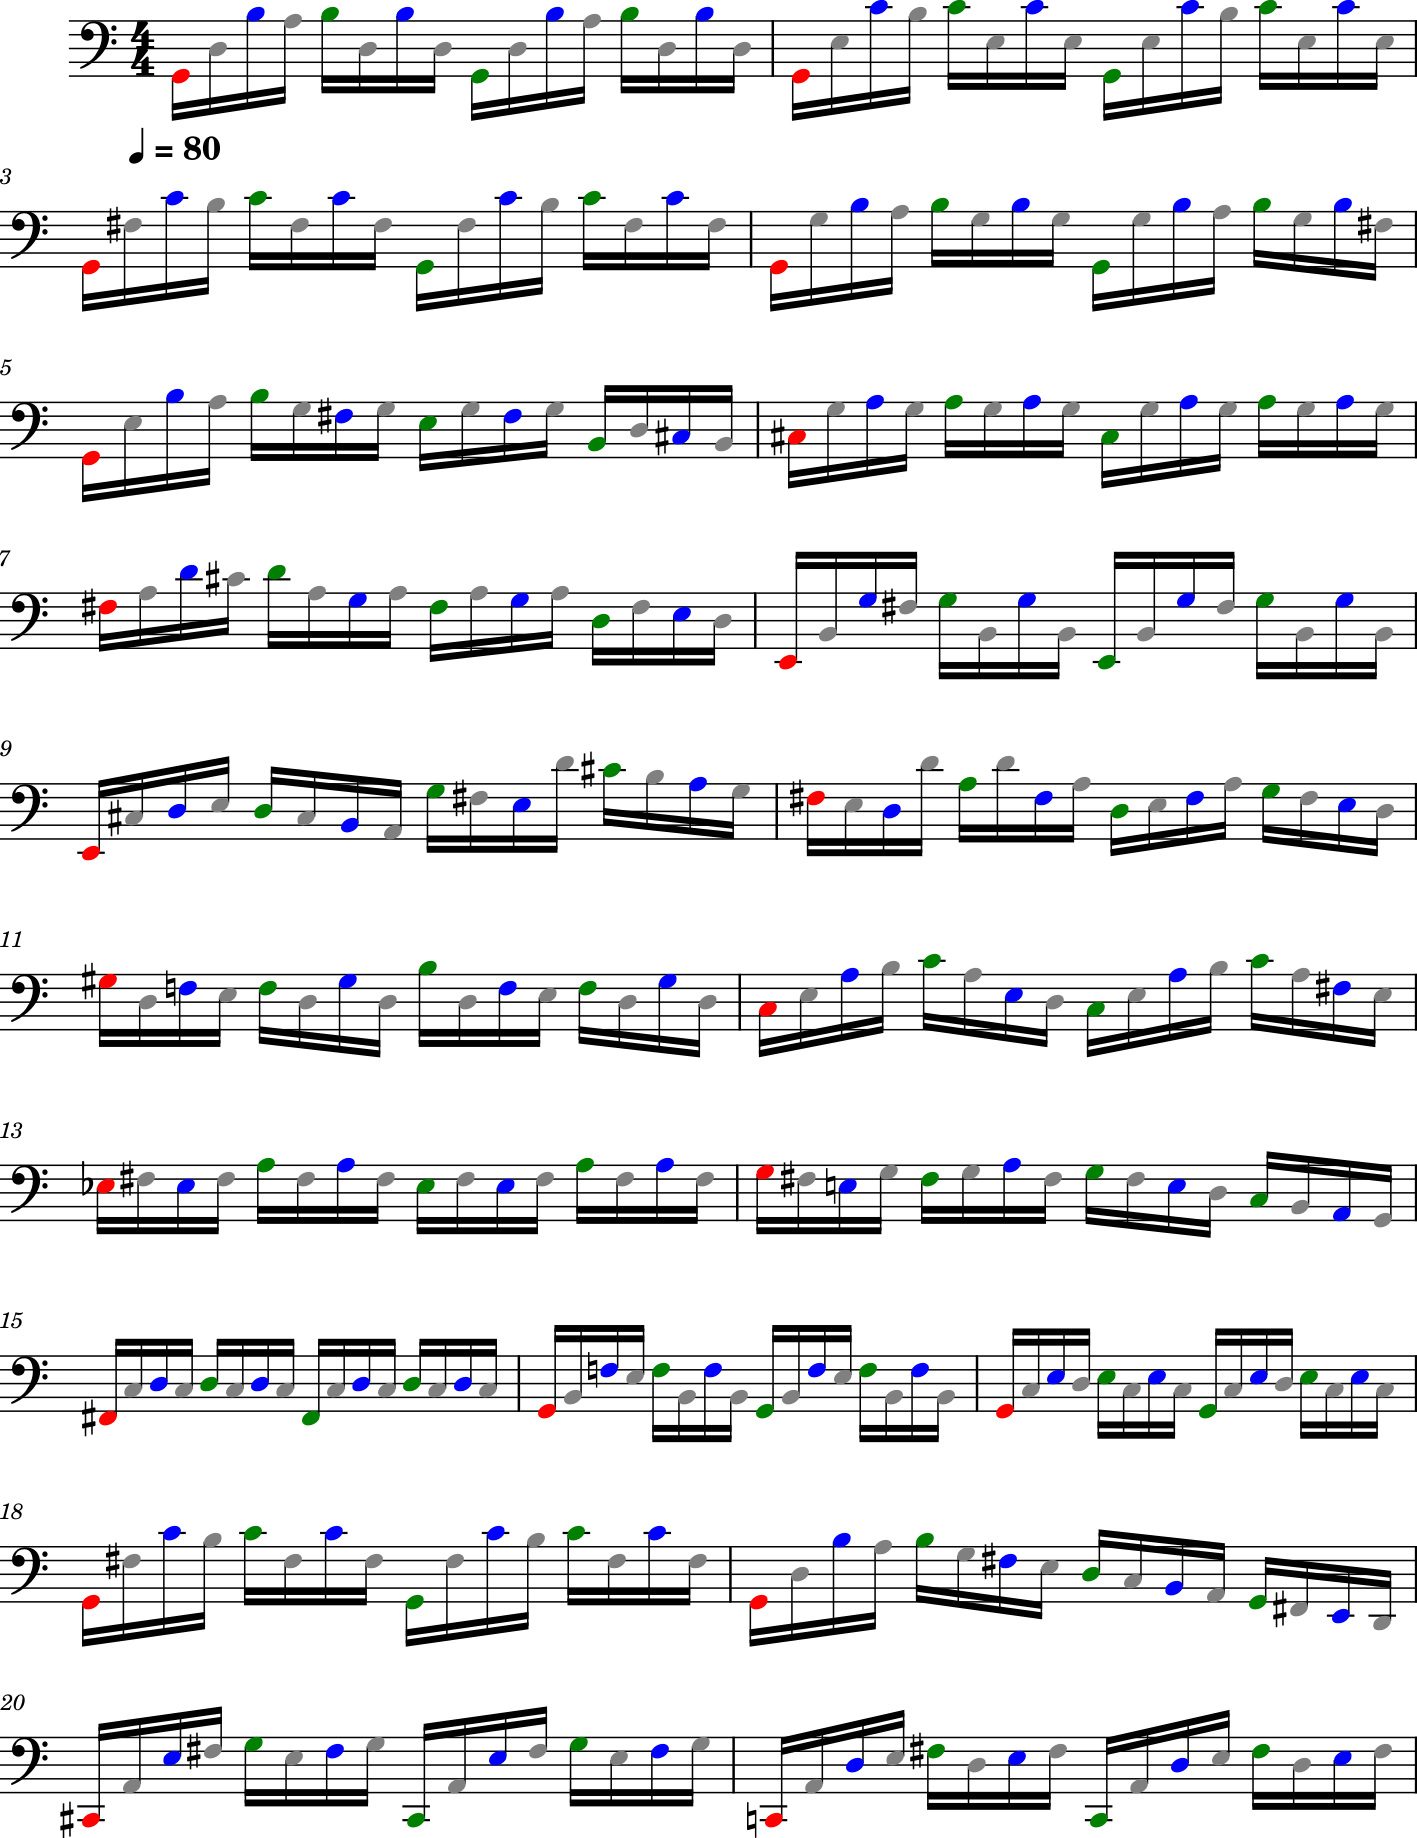

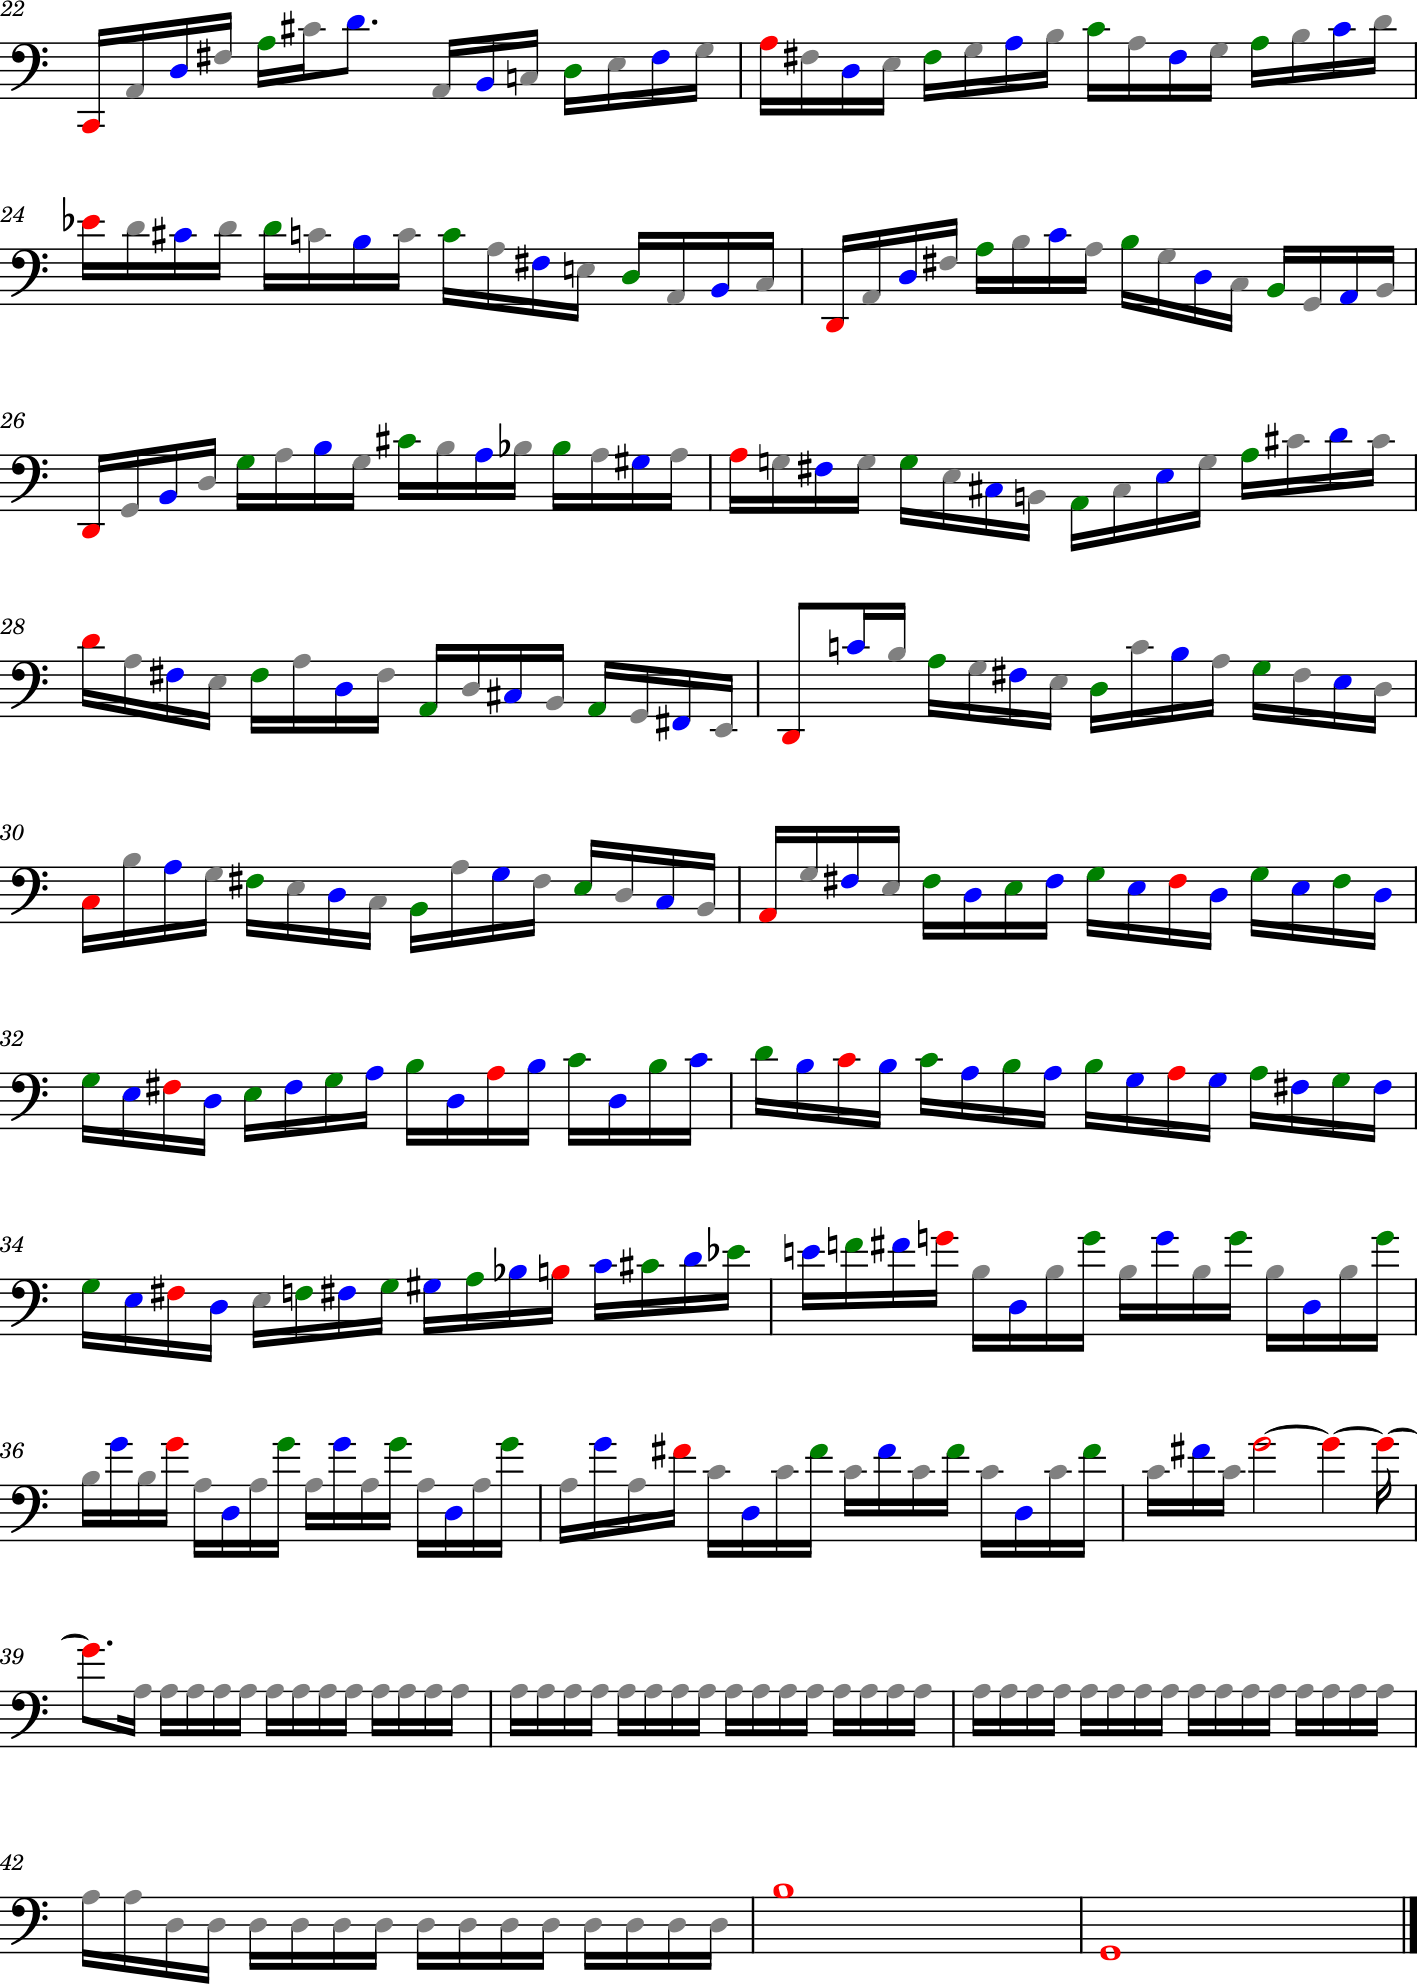

In [89]:
color = ['red','green','blue','gray','brown','pink','purple','black']
strm_lev = stream.Stream()
mm = tempo.MetronomeMark(number=BPM)
strm_lev.append(mm)  # tempo
strm_lev.append(instrument.Violoncello())  # instrument
for i in range(len(Beat_level)):
    n = note.Note()
    n.pitch.midi = Beat_level['Note'][i]
    n.duration.quarterLength = Beat_level['Duration_quarter'][i]
    n.style.color = color[Beat_level['Structure_level'][i]]
    strm_lev.append(n)
strm_lev.show()

### 7) Control

Track, Time, __Control_c__, Channel, Control_num, Value

Set the [controller Control_num](https://anotherproducer.com/online-tools-for-musicians/midi-cc-list/) on the given Channel to the specified Value. Control_num and Value must be in the inclusive range 0 to 127. The assignment of Control_num values to effects differs from instrument to instrument. The General MIDI specification defines the meaning of controllers:

- 1 (modulation) 

- 7 (volume) 

- 10 (pan) 

- 11 (expression) 

- 64 (sustain pedal): On/Off switch that controls sustain. 0 to 63 = Off, 64 to 127 = On

- 67 (soft pedal): On/Off switch that controls soft pedal. 0 to 63 = Off, 64 to 127 = On

but not all instruments and patches respond to these controllers. Instruments which support those capabilities usually assign: 

- 91 (reverberation)

- 93 (chorus)

In [90]:
df[df['Type']=="Control_c"]

,Track,Time,Type,Channel,Note,Velocity,Value
14,2,0,Control_c,0,7,100,NaN
15,2,0,Control_c,0,10,64,NaN
1207,3,0,Control_c,1,7,100,NaN
1208,3,0,Control_c,1,10,74,NaN
1338,4,0,Control_c,2,7,100,NaN
1339,4,0,Control_c,2,10,54,NaN


In Midi music generation, the control values are often ignored (most tasks focus solely on the note values and durations). In certain cases (such as the example we use) this term could be safely ignored without much influence. However, we will instantiate that this is not always true, which highlights the significance of getting hands on the raw data (exactly the efforts we are making here :) ) 

In [91]:
csv_string = pm.midi_to_csv('Songs/Arciglione08.MID')
csv_string

['0, 0, Header, 0, 1, 384\n',
 '1, 0, Start_track\n',
 '1, 0, Title_t, "Wasserklavier--Angelo Arciglione"\n',
 '1, 0, Text_t, "2006 International Piano-e-Competition Recital Round"\n',
 '1, 0, Text_t, "St. Paul, Minnesota, July 2006"\n',
 '1, 0, Text_t, "http://www.piano-e-competition.com/"\n',
 '1, 0, Instrument_name_t, "Yamaha Disklavier Pro Mark IV concert grand piano"\n',
 '1, 0, Sequencer_specific, 27, 43, 71, 00, 01, 00, 01, 00, 57, 61, 73, 73, 65, 72, 6B, 6C, 61, 76, 69, 65, 72, 20, 20, 20, 41, 6E, 67, 65, 6C, 6F, 41, 72, 63, 69, 67, 6C, 69, 6F, 6E, 65\n',
 '1, 0, Sequencer_specific, 06, 43, 71, 00, 00, 00, 45\n',
 '1, 0, System_exclusive, 15, 43, 71, 7E, 15, 00, 02, 02, 00, 0A, 0A, 0C, 04, 04, 0A, 0C, 03, 0B, 03, 0C, 02, F7\n',
 '1, 0, Sequencer_specific, 05, 43, 7B, 0C, 02, 01\n',
 '1, 0, Tempo, 512820\n',
 '1, 0, Time_signature, 4, 2, 24, 8\n',
 '1, 0, System_exclusive, 05, 7E, 7F, 09, 01, F7\n',
 '1, 1, System_exclusive, 08, 43, 10, 4C, 00, 00, 7E, 00, F7\n',
 '1, 2, System_

In [92]:
MyFile = open("Aligned.txt","w")

for element in csv_string:
    inst_list = element.split(", ");
    inst_list_len = len(inst_list)
    
    if inst_list_len == 6 and inst_list[2][-2:] != "_t":
        element = ','.join(inst_list)
            
    else:
        if inst_list_len == 3 and ','.join(inst_list)[-1] == "\n":
            element = ','.join(inst_list)[:-1] + ',-1'*3
        else:
            element = ','.join(inst_list[0:3]) + ',-1'*3 + ',' + ' '.join(inst_list[3:])

    MyFile.write(element)
    MyFile.write('\n')
    
MyFile.close()

In [93]:
df = pd.read_csv('Aligned.txt', sep=",",names = ["Track","Time","Type","Channel", "Note", "Velocity","Value"])
print(df)

      Track   Time         Type  Channel  Note  Velocity  \
0         0      0       Header        0     1       384   
1         1      0  Start_track       -1    -1        -1   
2         1      0      Title_t       -1    -1        -1   
3         1      0       Text_t       -1    -1        -1   
4         1      0       Text_t       -1    -1        -1   
...     ...    ...          ...      ...   ...       ...   
1832      1  83248    Control_c        0    64        37   
1833      1  83262    Control_c        0    64        33   
1834      1  83277    Control_c        0    64         0   
1835      1  83277    End_track       -1    -1        -1   
1836      0      0  End_of_file       -1    -1        -1   

                                                  Value  
0                                                   NaN  
1                                                   NaN  
2                      Wasserklavier--Angelo Arciglione  
3     2006 International Piano-e-Competition Re

In [94]:
Control = df[df['Type']=="Control_c"]
Control

,Track,Time,Type,Channel,Note,Velocity,Value
16,1,3,Control_c,0,0,0,NaN
17,1,4,Control_c,0,32,0,NaN
19,1,6,Control_c,0,7,100,NaN
20,1,907,Control_c,0,67,97,NaN
22,1,922,Control_c,0,67,103,NaN
...,...,...,...,...,...,...,...
1830,1,83210,Control_c,0,64,46,NaN
1831,1,83225,Control_c,0,64,42,NaN
1832,1,83248,Control_c,0,64,37,NaN
1833,1,83262,Control_c,0,64,33,NaN


In [95]:
df = df.drop(Control.index)
df = df.reset_index(drop=True)
df

,Track,Time,Type,Channel,Note,Velocity,Value
0,0,0,Header,0,1,384,NaN
1,1,0,Start_track,-1,-1,-1,NaN
2,1,0,Title_t,-1,-1,-1,Wasserklavier--Angelo Arciglione
3,1,0,Text_t,-1,-1,-1,2006 International Piano-e-Competition Recital...
4,1,0,Text_t,-1,-1,-1,St. Paul Minnesota July 2006
...,...,...,...,...,...,...,...
810,1,81382,Note_off_c,0,68,30,NaN
811,1,81402,Note_off_c,0,48,39,NaN
812,1,81738,Note_off_c,0,72,25,NaN
813,1,83277,End_track,-1,-1,-1,NaN


In [96]:
df.to_csv("dataframe.csv", header=False,index=False)

In [97]:
with open("dataframe.csv") as f_in, open("midifile.csv", 'w') as f_out:
    for element in f_in:
        inst_list = element.split(",")
        inst_list_len = len(inst_list)
    
        if inst_list[3] == '-1' and inst_list[4] == '-1':
            del inst_list[3:6]
            inst_list = inst_list[:-1] + inst_list[-1].split(" ")
            
        if inst_list[-1] == "\n" or inst_list[-1] == "":
            inst_list[-2] = inst_list[-2] + inst_list[-1]
            inst_list = inst_list[:-1]
            
        line = ",".join(inst_list)
        f_out.write(line)

In [98]:
# Parse the CSV output of the previous command back into a MIDI file
midi_object = pm.csv_to_midi("midifile.csv")

# Save the parsed MIDI file to disk
with open("C:/Users/79244/Desktop/no_control.mid", "wb") as output_file:
    midi_writer = pm.FileWriter(output_file)
    midi_writer.write(midi_object)

Listen to the differences in [Ableton Live](https://www.ableton.com/en/live/).

## Data Processing Methods

1) Time is measured at the absolute perceptual scale in real-life (micro)seconds.

2) The onset is incremental-based, which is described by time shift between events. We claim that there is no synchronous events, which means there is always time difference between the strikes of two notes.

3) Notes are discrete and independent, which is categorical within the range.

4) Velocity is described relatively, in relation to the previous velocity value. The sound is percepted as increasing or decreasing, by corresponding amount (dramatically or slightly), which maps better to the intuition of tendency and shape instead of categorical values.

5) The control numbers 64 (sustain pedal) and 67 (soft pedal) play tantamount role as the notes. They modify the timbre and quality of the sound, and illuminate important grouping structures of the performances. A resynthesis without pedal effects can hardly be considered musical from a listening perspective (refer to [this](https://magenta.tensorflow.org/performance-rnn)).

6) The metrical scale is considered more scientifically under the [Weber's law](https://www.khanacademy.org/test-prep/mcat/processing-the-environment/sensory-perception/v/webers-law-and-thresholds) (just noticeable difference) than equal division. 

In [3]:
file = "Songs\e_piano_comp.mid"
csv_string = pm.midi_to_csv(file)
csv_string

['0, 0, Header, 0, 1, 480\n',
 '1, 0, Start_track\n',
 '1, 0, Sequencer_specific, 06, 43, 71, 00, 00, 00, 43\n',
 '1, 0, Sequencer_specific, 27, 43, 71, 00, 01, 00, 01, 00, 45, 74, 75, 64, 65, 20, 4F, 70, 75, 73, 20, 31, 30, 2F, 34, 20, 4D, 2E, 20, 41, 64, 69, 67, 65, 7A, 61, 6C, 7A, 61, 64, 65, 20\n',
 '1, 0, Sequencer_specific, 05, 43, 7B, 0C, 00, 01\n',
 '1, 0, Tempo, 512820\n',
 '1, 0, Time_signature, 4, 2, 24, 8\n',
 '1, 0, System_exclusive, 05, 7E, 7F, 09, 01, F7\n',
 '1, 1, System_exclusive, 08, 43, 10, 4C, 00, 00, 7E, 00, F7\n',
 '1, 5, Control_c, 0, 0, 0\n',
 '1, 6, Control_c, 0, 32, 0\n',
 '1, 7, Program_c, 0, 0\n',
 '1, 8, Control_c, 0, 7, 100\n',
 '1, 199, Control_c, 0, 64, 15\n',
 '1, 390, Control_c, 0, 64, 31\n',
 '1, 581, Control_c, 0, 64, 45\n',
 '1, 772, Control_c, 0, 64, 63\n',
 '1, 963, Control_c, 0, 64, 75\n',
 '1, 1154, Control_c, 0, 64, 93\n',
 '1, 1345, Control_c, 0, 64, 105\n',
 '1, 1536, Control_c, 0, 64, 127\n',
 '1, 1918, Note_on_c, 0, 80, 91\n',
 '1, 1922, N

In [4]:
MyFile = open("Aligned.txt","w")

for element in csv_string:
    inst_list = element.split(", ");
    inst_list_len = len(inst_list)
    
    if inst_list_len == 6 and inst_list[2][-2:] != "_t": # exclude the coincidences when text events happen to have 6 entries
        element = ','.join(inst_list)
            
    else:
        if inst_list_len == 3 and ','.join(inst_list)[-1] == "\n": # 'End_of_fil'
            element = ','.join(inst_list)[:-1] + ',-1'*3 + "\n"
        else:
            element = ','.join(inst_list[0:3]) + ',-1'*3 + ',' + ' '.join(inst_list[3:])

    MyFile.write(element)
    
MyFile.close()

In [5]:
df = pd.read_csv('Aligned.txt', sep=",",names = ["Track","Time","Type","Channel", "Note", "Velocity","Value"])
print(df)

      Track    Time                Type  Channel  Note  Velocity  \
0         0       0              Header        0     1       480   
1         1       0         Start_track       -1    -1        -1   
2         1       0  Sequencer_specific       -1    -1        -1   
3         1       0  Sequencer_specific       -1    -1        -1   
4         1       0  Sequencer_specific       -1    -1        -1   
...     ...     ...                 ...      ...   ...       ...   
6476      1  116285           Control_c        0    64        28   
6477      1  116305           Control_c        0    64        16   
6478      1  116323           Control_c        0    64         0   
6479      1  116323           End_track       -1    -1        -1   
6480      0       0         End_of_file       -1    -1        -1   

                                                  Value  
0                                                   NaN  
1                                                   NaN  
2        

In [6]:
Control = df[df['Type']=="Control_c"]
Control

,Track,Time,Type,Channel,Note,Velocity,Value
9,1,5,Control_c,0,0,0,NaN
10,1,6,Control_c,0,32,0,NaN
12,1,8,Control_c,0,7,100,NaN
13,1,199,Control_c,0,64,15,NaN
14,1,390,Control_c,0,64,31,NaN
...,...,...,...,...,...,...,...
6474,1,116230,Control_c,0,64,41,NaN
6475,1,116268,Control_c,0,64,35,NaN
6476,1,116285,Control_c,0,64,28,NaN
6477,1,116305,Control_c,0,64,16,NaN


In [7]:
control_nums = np.unique(np.array(Control['Note']))
control_nums

array([ 0,  7, 32, 64, 67], dtype=int64)

### 1) Processing Pedal Information
 
 The pedals are treated as binary values, On/Off. 0 to 49 = Off, 50 to 127 = On
 
 - Sustain pedal (64)
 - Soft pedal (67)
 
 As sustain pedal has more dramastic effects on piano performance, within the scope of this work, we only incorporate sustain pedal into the training dataset.

In [8]:
Sustain_ctr = Control[Control['Note'] == 64].reset_index(drop=True)
Sustain_ctr

,Track,Time,Type,Channel,Note,Velocity,Value
0,1,199,Control_c,0,64,15,NaN
1,1,390,Control_c,0,64,31,NaN
2,1,581,Control_c,0,64,45,NaN
3,1,772,Control_c,0,64,63,NaN
4,1,963,Control_c,0,64,75,NaN
...,...,...,...,...,...,...,...
1443,1,116230,Control_c,0,64,41,NaN
1444,1,116268,Control_c,0,64,35,NaN
1445,1,116285,Control_c,0,64,28,NaN
1446,1,116305,Control_c,0,64,16,NaN


In [16]:
cof = 1/PPQ*MSQ/1000
Sustain = pd.DataFrame(columns=['Time_ms','Status'])
time_on = Sustain_ctr['Time'][0]
if Sustain_ctr["Velocity"][0] < 50:
    switch = 0
else:
    switch = 1
Sustain = pd.concat([Sustain, pd.DataFrame([{'Time_ms': time_on*cof,
                 'Status': switch}])], ignore_index=True)

for i in range(1,len(Sustain_ctr)):
    if Sustain_ctr["Velocity"][i] < 50 and switch == 1:
        time_on = Sustain_ctr['Time'][i]
        switch = 0
        Sustain = pd.concat([Sustain, pd.DataFrame([{'Time_ms': time_on*cof,
                 'Status': switch}])], ignore_index=True)
    if Sustain_ctr["Velocity"][i] >= 50 and switch == 0:
        time_on = Sustain_ctr['Time'][i]
        switch = 1
        Sustain = pd.concat([Sustain, pd.DataFrame([{'Time_ms': time_on*cof,
                 'Status': switch}])], ignore_index=True)
        
Sustain = Sustain.astype({
    'Time_ms': np.int64,
    'Status': np.int64
})

In [17]:
Sustain

,Time_ms,Status
0,212,0
1,824,1
2,2323,0
3,2400,1
4,2771,0
...,...,...
324,114404,0
325,114837,1
326,115580,0
327,117933,1


### 2) Mel-Quantization

<img src="division_1.png" style="width:800px">
<caption><center> Figure 1. The categorical distributions for given input features. The divisions obey Weber's law where the perceptual changes are proportional to the values. </center></caption>

These quantization scales are computed statistically over the entire dateset, which corresponds to the theoretical mel-scale. The perception-based data processing better reflects the listening-perception reality of human auditory systems, which excels the linear scales.